In [1]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')


from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool

In [2]:
gpuid = 1
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

1


In [3]:
from clsar.dataset import LSSNS # dataset
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility # model
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [4]:
dataset_name = 'braf'
Dataset =  LSSNS # MoleculeNet
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '/tmp/mydata'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(123)

In [5]:
# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
deg = get_deg(train_dataset)
#cliff_lower, cliff_upper, n = get_best_cliff(train_dataset.data.y)
cliff_lower, cliff_upper = 1.0, 1.0

In [7]:

def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets


@torch.no_grad()
def test(loader):
    model.eval()
    mse = []
    for data in loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            #'batch_norms':None, 
            'dropout_p': 0}

## Cliff Awaness factor: 1.0

In [8]:
model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum','std'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)
                   
optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=10**-5)

aca_loss = ACALoss(alpha=1.0, cliff_lower = cliff_lower, cliff_upper = cliff_upper)


history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
          f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df1 = pd.DataFrame(history)

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 16.3708 tsm_loss: 9.8844 reg_loss: 6.4864 n_pos_triplets: 27899;  Val: 6.3659 Test: 6.5105
Epoch: 002, Loss: 9.3097 tsm_loss: 2.9301 reg_loss: 6.3796 n_pos_triplets: 19893;  Val: 6.3652 Test: 6.5098
Epoch: 003, Loss: 7.6328 tsm_loss: 1.3572 reg_loss: 6.2757 n_pos_triplets: 14302;  Val: 6.3647 Test: 6.5092
Epoch: 004, Loss: 7.1016 tsm_loss: 0.9431 reg_loss: 6.1584 n_pos_triplets: 11597;  Val: 6.3642 Test: 6.5088
Epoch: 005, Loss: 6.6587 tsm_loss: 0.6104 reg_loss: 6.0483 n_pos_triplets: 8747;  Val: 6.3639 Test: 6.5085
Epoch: 006, Loss: 6.3496 tsm_loss: 0.4212 reg_loss: 5.9284 n_pos_triplets: 7144;  Val: 6.3638 Test: 6.5084
Epoch: 007, Loss: 6.1358 tsm_loss: 0.3372 reg_loss: 5.7986 n_pos_triplets: 6468;  Val: 6.3636 Test: 6.5082
Epoch: 008, Loss: 5.9253 tsm_loss: 0.2681 reg_loss: 5.6571 n_pos_triplets: 5779;  Val: 6.3634 Test: 6.5080
Epoch: 009, Loss: 5.7188 tsm_loss: 0.2151 reg_loss: 5.5037 n_pos_triplets: 4788;  Val: 6.3632 Test: 6.5078
Epoch: 010, Loss: 5.5216 tsm_los

In [9]:
df1

,Epoch,train_loss,train_triplet_loss,train_mae_loss,val_rmse,test_rmse,n_triplets,n_pos_triplets
0,1,16.370819,9.884436,6.486382,6.365925,6.510473,54162,27899
1,2,9.309706,2.930147,6.379559,6.365217,6.509768,54162,19893
2,3,7.632842,1.357179,6.275662,6.364654,6.509222,54162,14302
3,4,7.101555,0.943125,6.158431,6.364231,6.508814,54162,11597
4,5,6.658746,0.610411,6.048336,6.363935,6.508522,54162,8747
...,...,...,...,...,...,...,...,...
794,795,0.031168,0.000609,0.030559,0.540831,0.344575,54162,60
795,796,0.026496,0.000405,0.026090,0.536027,0.349098,54162,47
796,797,0.022363,0.000329,0.022034,0.548958,0.337950,54162,46
797,798,0.023609,0.000204,0.023405,0.568841,0.351279,54162,35


In [10]:
aca_loss.cliff_lower

1.0

## Cliff Awaness factor: 0

In [11]:
## model HPs
model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum', 'std'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)
                   
optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=10**-5)

aca_loss = ACALoss(alpha=0.0, cliff_lower = cliff_lower, cliff_upper = cliff_upper)

history = []
#ls_his = []
for epoch in range(1, epochs):
    train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    
    print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
          f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')

    history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                    'val_rmse':val_rmse, 'test_rmse':test_rmse, 'n_triplets': n_triplets, 'n_pos_triplets':n_pos_triplets})
    #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
df2 = pd.DataFrame(history)

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 001, Loss: 6.8399 tsm_loss: 10.9466 reg_loss: 6.8399 n_pos_triplets: 30780;  Val: 6.4821 Test: 6.6263
Epoch: 002, Loss: 6.4993 tsm_loss: 10.9190 reg_loss: 6.4993 n_pos_triplets: 30734;  Val: 6.4815 Test: 6.6258
Epoch: 003, Loss: 6.2322 tsm_loss: 11.7426 reg_loss: 6.2322 n_pos_triplets: 30590;  Val: 6.4808 Test: 6.6251
Epoch: 004, Loss: 6.0156 tsm_loss: 12.0705 reg_loss: 6.0156 n_pos_triplets: 29687;  Val: 6.4803 Test: 6.6246
Epoch: 005, Loss: 5.8285 tsm_loss: 12.5041 reg_loss: 5.8285 n_pos_triplets: 29180;  Val: 6.4797 Test: 6.6240
Epoch: 006, Loss: 5.6455 tsm_loss: 12.8473 reg_loss: 5.6455 n_pos_triplets: 28753;  Val: 6.4792 Test: 6.6235
Epoch: 007, Loss: 5.4629 tsm_loss: 13.2676 reg_loss: 5.4629 n_pos_triplets: 28546;  Val: 6.4784 Test: 6.6227
Epoch: 008, Loss: 5.2848 tsm_loss: 13.7094 reg_loss: 5.2848 n_pos_triplets: 28528;  Val: 6.4774 Test: 6.6217
Epoch: 009, Loss: 5.1106 tsm_loss: 14.1213 reg_loss: 5.1106 n_pos_triplets: 28728;  Val: 6.4765 Test: 6.6208
Epoch: 010, Loss: 4

In [12]:
df2 = pd.DataFrame(history)

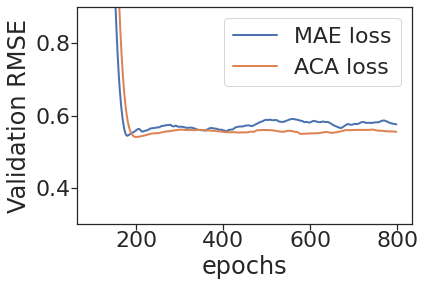

In [63]:
ax = df2.val_rmse.to_frame(name = 'MAE loss').join(df1.val_rmse.to_frame(name = 'ACA loss')).rolling(100).mean().plot(lw = 2)
ax.set_ylim(0.3, 0.9)

ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

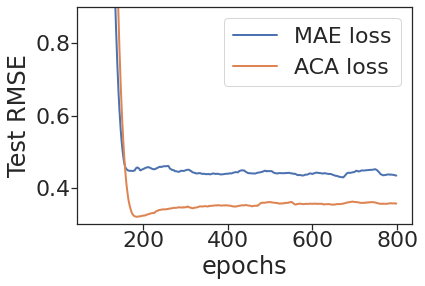

In [57]:
ax = df2.test_rmse.to_frame(name = 'MAE loss').join(df1.test_rmse.to_frame(name = 'ACA loss')).rolling(80).mean().plot(lw = 2)
ax.set_ylim(0.3, 0.9)

ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

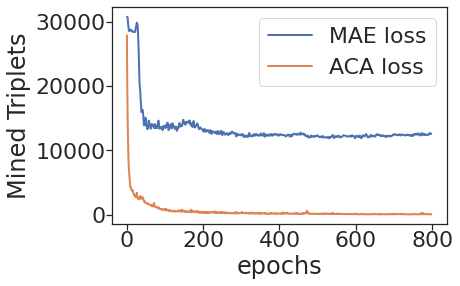

In [58]:
ax = df2.n_pos_triplets.to_frame(name = 'MAE loss').join(df1.n_pos_triplets.to_frame(name = 'ACA loss')).rolling(1).mean().plot(lw=2)
ax.set_ylabel('Mined Triplets')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

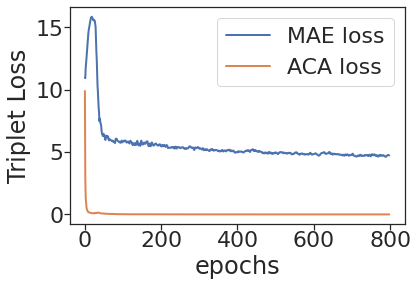

In [65]:
ax = df2.train_triplet_loss.to_frame(name = 'MAE loss').join(df1.train_triplet_loss.to_frame(name = 'ACA loss')).plot(lw=2)
ax.set_ylabel('Triplet Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)

In [60]:
df2

,Epoch,train_loss,train_triplet_loss,train_mae_loss,val_rmse,test_rmse,n_triplets,n_pos_triplets
0,1,6.839869,10.946611,6.839869,6.482055,6.626333,54162,30780
1,2,6.499302,10.918975,6.499302,6.481509,6.625789,54162,30734
2,3,6.232227,11.742637,6.232227,6.480785,6.625057,54162,30590
3,4,6.015561,12.070530,6.015561,6.480295,6.624578,54162,29687
4,5,5.828497,12.504087,5.828497,6.479745,6.624013,54162,29180
...,...,...,...,...,...,...,...,...
794,795,0.023220,4.758087,0.023220,0.551746,0.429685,54162,12672
795,796,0.021109,4.761885,0.021109,0.565871,0.443827,54162,12578
796,797,0.033517,4.753047,0.033517,0.564331,0.436369,54162,12543
797,798,0.018376,4.740345,0.018376,0.557434,0.421337,54162,12564


In [61]:
aca_loss.alpha

0.0